In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yfin
plt.style.use('seaborn')

In [37]:
!pip uninstall yahoofinance

^C


In [2]:
df = pd.read_csv("S&P500 dataset.xlsx - Dataset .csv", index_col=1, header=2).iloc[:, :-1]

df.head()

,Company Name,GICS Sector,ESG Rating,Status,Full Time Employee
Exchange:Ticker,,,,,
NYSE:MMM,3M Company,Industrials,34.9,High Risk,"95,000"
NYSE:AOS,A. O. Smith Corporation,Industrials,25.2,Medium Risk,"13,900"
NYSE:ABT,Abbott Laboratories,Health Care,26.0,Medium Risk,"109,000"
NYSE:ABBV,AbbVie Inc.,Health Care,28.0,Medium Risk,"50,000"
NasdaqGS:ABMD,"Abiomed, Inc.",Health Care,32.8,High Risk,"1,725"


<AxesSubplot:ylabel='Frequency'>

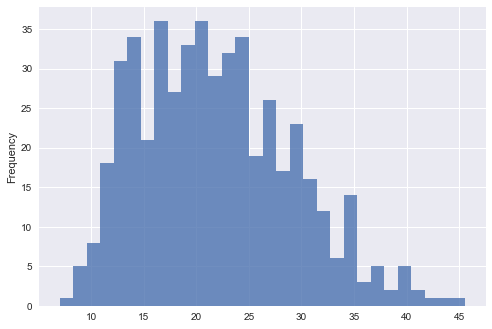

In [3]:
df['ESG Rating'].plot(kind='hist', bins=30, alpha=0.8)

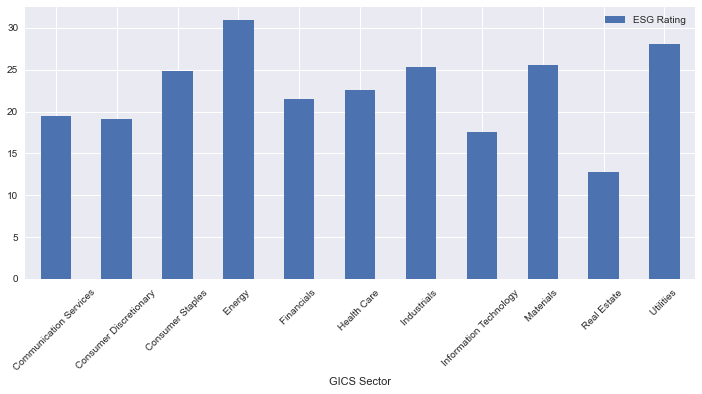

In [4]:
df.groupby('GICS Sector').mean().plot(kind='bar', figsize=(12, 5))
plt.xticks(rotation=45)
plt.show()

In [12]:
sector_ticker_dict = dict(zip([x.split(sep=':')[1] for x in df.index], df['GICS Sector']))

In [62]:
cpi = pd.read_csv('CPIAUCSL.csv', index_col=0, parse_dates=True).pct_change(12) * 100
cpi = cpi.resample('M').mean()

<AxesSubplot:xlabel='DATE'>

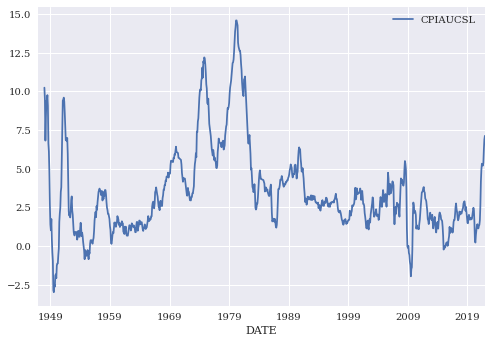

In [63]:
cpi.plot()

In [13]:
historical_price = yfin.download(tickers = list(sector_ticker_dict.keys()), interval='1mo', start_date='2000-01-01')['Adj Close']

[*********************100%***********************]  500 of 500 completed

4 Failed downloads:
- DISC.A: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted
- BRK.A: No data found, symbol may be delisted
- CMCS.A: No data found, symbol may be delisted


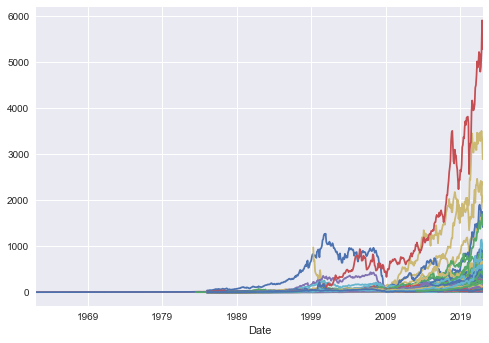

In [21]:
historical_price.resample('M').mean().plot()
plt.legend([])
plt.show()

In [23]:
historical_price = historical_price["2000":]

In [24]:
historical_price.to_csv("historical_price.csv")

<AxesSubplot:xlabel='DATE'>

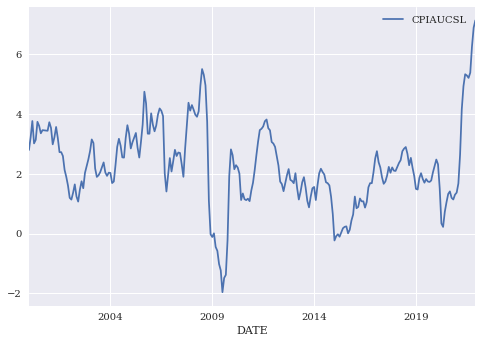

In [152]:
cpi["2000":].plot()

In [78]:
historical_returns = historical_price.resample('M').mean().pct_change() * 100

In [153]:
cpi_level = 3

high_cpi_months = cpi[cpi > cpi_level]["2000":].index

high_cpi_returns = historical_returns.loc[high_cpi_months, ]

In [154]:
high_cpi_returns.dropna(how='all', inplace=True)
high_cpi_returns.fillna(0, inplace=True)

In [156]:
from tqdm import tqdm
from collections import Counter

industry_filter = pd.DataFrame(columns = list(Counter(sector_ticker_dict.values()).keys()))

for date in tqdm(high_cpi_returns.index):

    from collections import Counter

    sorted_returns = sorted(list(high_cpi_returns.loc[date].to_dict().items()), key = lambda x: x[1], reverse=True)

    best_quartile_returns = [ticker[0] for ticker in sorted_returns[: int(len(sorted_returns) // 4)]]
    best_quartile_returns_by_industry = Counter(list(map(lambda x: sector_ticker_dict[x], best_quartile_returns)))

    industry_filter = industry_filter.append(best_quartile_returns_by_industry, ignore_index=True)

industry_filter.index = high_cpi_returns.index   

100%|██████████| 263/263 [00:00<00:00, 374.58it/s]


In [163]:
(industry_filter.sum(axis=0) / sum(industry_filter.sum(axis=0))) * 100

Industrials                13.551331
Health Care                13.788593
Information Technology     16.288973
Communication Services      3.954373
Consumer Discretionary     13.463118
Financials                 12.073004
Materials                    5.35057
Real Estate                 6.013688
Utilities                   5.110266
Consumer Staples            5.624335
Energy                      4.781749
dtype: object

In [176]:
df['GICS Sector']

Exchange:Ticker
NYSE:MMM                    Industrials 
NYSE:AOS                    Industrials 
NYSE:ABT                    Health Care 
NYSE:ABBV                   Health Care 
NasdaqGS:ABMD               Health Care 
                          ...           
NYSE:YUM         Consumer Discretionary 
NasdaqGS:ZBRA    Information Technology 
NYSE:ZBH                    Health Care 
NasdaqGS:ZION                Financials 
NYSE:ZTS                    Health Care 
Name: GICS Sector, Length: 500, dtype: object

In [ ]:
df['ESG Rating']

In [180]:
# Looking at top 5 industries
top_gainer_industries = industry_filter.sum(axis=0).sort_values().index[-5:].tolist()

ESG_LEVEL = 30

df[list(df['GICS Sector'].isin(top_gainer_industries)) and list(df['ESG Rating'] > ESG_LEVEL)]

,Company Name,GICS Sector,ESG Rating,Status,Full Time Employee
Exchange:Ticker,,,,,
NYSE:MMM,3M Company,Industrials,34.9,High Risk,"95,000"
NasdaqGS:ABMD,"Abiomed, Inc.",Health Care,32.8,High Risk,"1,725"
NasdaqGS:AEP,"American Electric Power Company, Inc.",Utilities,30.8,High Risk,"16,787"
NYSE:ADM,Archer-Daniels-Midland Company,Consumer Staples,36.4,High Risk,"37,575"
NYSE:ATO,Atmos Energy Corporation,Utilities,31.8,High Risk,"4,684"
...,...,...,...,...,...
NasdaqGS:UAL,"United Airlines Holdings, Inc.",Industrials,30.2,High Risk,"85,300"
NYSE:UNH,UnitedHealth Group Incorporated,Health Care,30.9,High Risk,"68,100"
NYSE:VLO,Valero Energy Corporation,Energy,30.7,High Risk,"9,803"


In [138]:
# Tickers in each industry in sp500
Counter(sector_ticker_dict.values())

Counter({'Industrials ': 72,
         'Health Care ': 64,
         'Information Technology ': 76,
         'Communication Services ': 23,
         'Consumer Discretionary ': 60,
         'Financials ': 67,
         'Materials ': 28,
         'Real Estate ': 29,
         'Utilities ': 28,
         'Consumer Staples ': 32,
         'Energy ': 21})